# XGB with Engineered Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train_df = pd.read_csv(r'C:\Users\Issei\Desktop\Class Documents\KEIO 2024 Fall\Data Science\Datasets\out\train_tokyo.csv', index_col=0)
test_df = pd.read_csv(r"C:\Users\Issei\Desktop\Class Documents\KEIO 2024 Fall\Data Science\Datasets\out\test_tokyo.csv", index_col=0)
answer_df = pd.read_csv(r"C:\Users\Issei\Desktop\Class Documents\KEIO 2024 Fall\Data Science\Datasets\out\answer_tokyo.csv")

In [4]:
train_df.head()

,物件ID,自社物フラグ,物件種別,空き物件数,都道府県,市区郡町村,路線1,駅1,徒歩距離1,路線2,...,駐車場距離,現況,引渡/入居時期,コンビニ距離,スーパー距離,取引態様,バス停有り,その他費用,行政区域コード,平均地価
0,da11daf7e9f021eef09588fcdbdcec67,0,3101,1.0,13,224,863.0,4949,160.0,1000.0,...,-1,-1.0,1,2,4,6,True,0.0,13224,238928.571429
1,675e2a8d86de283bea808e4daf27a70f,0,3101,1.0,13,201,105.0,730,1200.0,105.0,...,1,-1.0,3,4,4,6,False,28080.0,13201,135000.000000
2,51c206b43e7726cd747dca15a8bd6ec2,0,3101,1.0,13,105,583.0,6381,320.0,577.0,...,-1,2.0,1,-1,-1,6,False,0.0,13105,654200.000000
3,dcdf3fd8ca3d0740b5a01aa339b417d1,0,3101,1.0,13,115,194.0,762,560.0,871.0,...,2,2.0,1,2,3,6,False,0.0,13115,534000.000000
4,12bf596823eafcfddb5a015761bde50b,0,3101,1.0,13,113,863.0,4925,400.0,863.0,...,-1,2.0,1,-1,-1,6,False,41200.0,13113,991666.666667


In [5]:
answer_df.head()

,賃料/価格
0,43000
1,70000
2,78000
3,69600
4,67000


In [6]:
train_df.drop('物件ID', axis=1, inplace=True)
train_df.drop('敷金', axis=1, inplace=True)
train_df.drop('礼金', axis=1, inplace=True)
test_df.drop('物件ID', axis=1, inplace=True)
test_df.drop('敷金', axis=1, inplace=True)
test_df.drop('礼金', axis=1, inplace=True)

In [7]:
# import xgb and other libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = train_df.drop('賃料/価格', axis=1)
y = train_df['賃料/価格']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1)
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, preds))
print(score)


65887.07796478042


In [8]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = np.square(error) / 2
    linear_loss = delta * (np.abs(error) - delta / 2)
    return np.where(is_small_error, squared_loss, linear_loss).mean()

In [9]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.38, 0.43),
        'lambda': trial.suggest_float('lambda', 0.60, 0.69),
        'learning_rate': trial.suggest_float('learning_rate', 0.018, 0.02),
        'max_depth': 13,
        'min_child_weight': 1,
        'alpha': trial.suggest_float('alpha', 0.5, 0.55),
        'gamma': trial.suggest_float('gamma', 0.65, 0.70),
        'subsample': trial.suggest_float('subsample', 0.97, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.45, 0.48),
        'seed': 123
    }
    
    # Convert the data to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Train the model with `num_boost_round`
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=trial.suggest_int('num_boost_round', 370, 400),
        evals=[(dtest, 'validation')],
        early_stopping_rounds=5,
        verbose_eval=False
    )
    
    # Predict and calculate RMSE
    preds = bst.predict(dtest)
    score = np.sqrt(mean_squared_error(y_test, preds))
    return score

# Create and optimize the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1, n_jobs=10)

print(study.best_params, study.best_value)


C:\Users\Issei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-15 14:03:31,582] A new study created in memory with name: no-name-5c23b890-2fa7-42ad-98d3-0d4117916833
[I 2025-01-15 14:03:35,265] Trial 0 finished with value: 57647.302640338734 and parameters: {'colsample_bytree': 0.40732842796940116, 'lambda': 0.6072554643216784, 'learning_rate': 0.018024963590392202, 'alpha': 0.5117189932181953, 'gamma': 0.6545934782964303, 'subsample': 0.9878249737775052, 'colsample_bylevel': 0.4738578758749901, 'num_boost_round': 399}. Best is trial 0 with value: 57647.302640338734.


{'colsample_bytree': 0.40732842796940116, 'lambda': 0.6072554643216784, 'learning_rate': 0.018024963590392202, 'alpha': 0.5117189932181953, 'gamma': 0.6545934782964303, 'subsample': 0.9878249737775052, 'colsample_bylevel': 0.4738578758749901, 'num_boost_round': 399} 57647.302640338734


53864.04938372861 and parameters: {'colsample_bytree': 0.42796899128577376, 'lambda': 0.6468520021140538, 'learning_rate': 0.018001323231869395, 'alpha': 0.5470546828854458, 'gamma': 0.6867378623374889, 'subsample': 0.9866791994360189, 'colsample_bylevel': 0.4773390892942839, 'num_boost_round': 380}. Best is trial 502 with value: 53864.04938372861.

In [10]:
# 以前チューニングしたパラメータ
best_params_1 = {'colsample_bytree': 0.42034609055475514, 'lambda': 0.6762895065509983, 'learning_rate': 0.018867542811951306, 'max_depth': 13, 'min_child_weight': 1, 'alpha': 0.5336472588050329, 'gamma': 0.6510749282340125, 'subsample': 0.9995715079391045, 'colsample_bylevel': 0.46391297205852455, 'num_boost_round': 383}

In [11]:
# Calculate the actual score (best_params_1)
X_leaderboard = test_df
y_leaderboard = answer_df['賃料/価格']

best_params = study.best_params
bst_num_boost_round = best_params_1.pop('num_boost_round')
dleaderboard = xgb.DMatrix(X_leaderboard, label=y_leaderboard)
bst = xgb.train(params=best_params_1, dtrain=dleaderboard, num_boost_round=bst_num_boost_round) #243
preds = bst.predict(dleaderboard)
score = np.sqrt(mean_squared_error(y_leaderboard, preds))
print('RMSE: ', score)
print(best_params_1)

RMSE:  3962.2457608787013
{'colsample_bytree': 0.42034609055475514, 'lambda': 0.6762895065509983, 'learning_rate': 0.018867542811951306, 'max_depth': 13, 'min_child_weight': 1, 'alpha': 0.5336472588050329, 'gamma': 0.6510749282340125, 'subsample': 0.9995715079391045, 'colsample_bylevel': 0.46391297205852455}


In [13]:
# caluculate the huber loss
print('Huber Loss: ', huber_loss(y_leaderboard, preds))

Huber Loss:  2684.366567847912


In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    rf = RandomForestRegressor(**params, random_state=123)
    score = cross_val_score(rf, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return np.sqrt(-score)

# Create and optimize the study
rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(rf_objective, n_trials=1, n_jobs=-1)

print(rf_study.best_params, rf_study.best_value)

[I 2025-01-15 13:57:42,004] A new study created in memory with name: no-name-cf5ae1a0-e7b2-4b4d-8537-a030e953fc1c


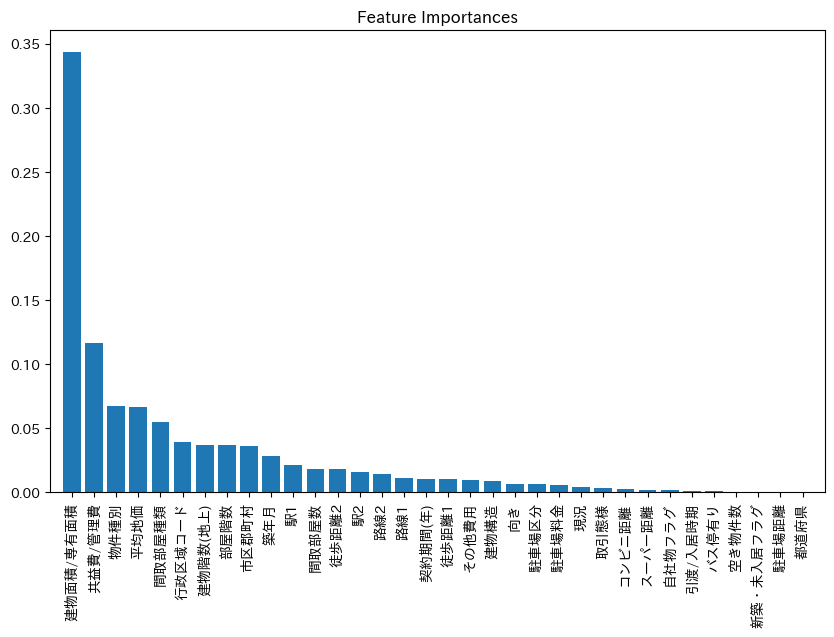

In [11]:
import japanize_matplotlib
# Fit the RandomForestRegressor with the best parameters
best_rf_params = rf_study.best_params
rf = RandomForestRegressor(**best_rf_params, random_state=123)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()